In [6]:
import networkx as nx
from GraphGenusGenerator import GraphGenusGenerator

In [7]:
problem = GraphGenusGenerator().generate(seed=123358, number_of_nodes=4, max_connections_per_node=3, complete_graph=True)

AttributeError: 'dict' object has no attribute 'is_directed'

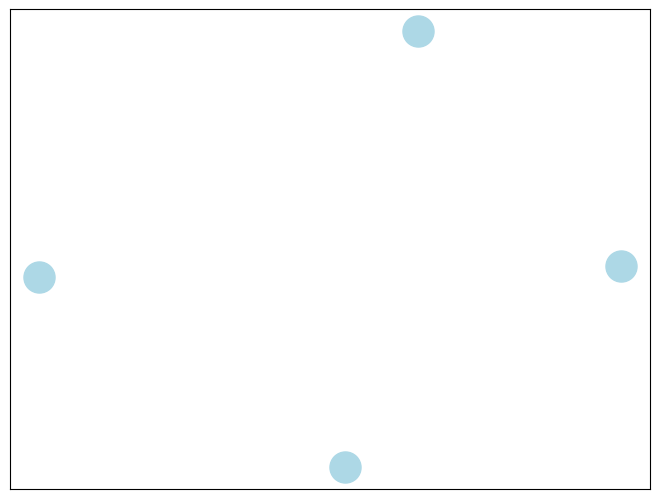

In [8]:
# Get the adjacency list (which is a graph object)
graph = problem.adj_list

# Draw the generated graph
import matplotlib.pyplot as plt
nx.draw(graph, with_labels=True, node_color='lightblue', node_size=500, font_size=10, font_weight='bold')
plt.title("Input Graph for Graph Genus Problem")
plt.show()

In [9]:
for i in problem.adj_list:
    print(i, problem.adj_list[i])


0 [1, 2, 3]
1 [0, 2, 3]
2 [0, 1, 3]
3 [0, 1, 2]


In [10]:
for i in problem.find_neighbors():
    print(i)

{0: [1, 2, 3], 1: [0, 2, 3], 2: [0, 1, 3], 3: [0, 1, 2]}
{0: [2, 1, 3], 1: [0, 2, 3], 2: [0, 1, 3], 3: [0, 1, 2]}
{0: [3, 2, 1], 1: [0, 2, 3], 2: [0, 1, 3], 3: [0, 1, 2]}
{0: [1, 3, 2], 1: [0, 2, 3], 2: [0, 1, 3], 3: [0, 1, 2]}
{0: [1, 2, 3], 1: [2, 0, 3], 2: [0, 1, 3], 3: [0, 1, 2]}
{0: [1, 2, 3], 1: [3, 2, 0], 2: [0, 1, 3], 3: [0, 1, 2]}
{0: [1, 2, 3], 1: [0, 3, 2], 2: [0, 1, 3], 3: [0, 1, 2]}
{0: [1, 2, 3], 1: [0, 2, 3], 2: [1, 0, 3], 3: [0, 1, 2]}
{0: [1, 2, 3], 1: [0, 2, 3], 2: [3, 1, 0], 3: [0, 1, 2]}
{0: [1, 2, 3], 1: [0, 2, 3], 2: [0, 3, 1], 3: [0, 1, 2]}
{0: [1, 2, 3], 1: [0, 2, 3], 2: [0, 1, 3], 3: [1, 0, 2]}
{0: [1, 2, 3], 1: [0, 2, 3], 2: [0, 1, 3], 3: [2, 1, 0]}
{0: [1, 2, 3], 1: [0, 2, 3], 2: [0, 1, 3], 3: [0, 2, 1]}


In [12]:
print(problem.random_neighbor())

TypeError: GraphGenusOpt.random_neighbor() missing 1 required positional argument: 'state'